In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#export
from exp.nb_04 import *

In [4]:
plot_themes()

In [5]:
x_train,y_train,x_valid,y_valid = get_data(mnist_path)

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [6]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [7]:
nfs = [8,16,32,64,64]

In [8]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [9]:
%timeit run.fit(2, learn)

train: [1.47675453125, tensor(0.5027, device='cuda:0')]
valid: [0.2969380126953125, tensor(0.9098, device='cuda:0')]
train: [0.2249705859375, tensor(0.9311, device='cuda:0')]
valid: [0.16578570556640626, tensor(0.9497, device='cuda:0')]
train: [0.12309466796875, tensor(0.9619, device='cuda:0')]
valid: [0.11428150634765626, tensor(0.9653, device='cuda:0')]
train: [0.0867031640625, tensor(0.9739, device='cuda:0')]
valid: [0.08992788696289063, tensor(0.9742, device='cuda:0')]
train: [0.070447763671875, tensor(0.9777, device='cuda:0')]
valid: [0.07657020263671875, tensor(0.9781, device='cuda:0')]
train: [0.08720134765625, tensor(0.9729, device='cuda:0')]
valid: [0.07926349487304687, tensor(0.9794, device='cuda:0')]
train: [0.049641357421875, tensor(0.9841, device='cuda:0')]
valid: [0.08934713745117187, tensor(0.9746, device='cuda:0')]
train: [0.0421379638671875, tensor(0.9867, device='cuda:0')]
valid: [0.07471414794921875, tensor(0.9798, device='cuda:0')]
train: [0.0374044384765625, tensor

## Custom Batchnorm

In [10]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [11]:
xb, yb=next(iter(data.train_dl))

In [13]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [14]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [15]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.27852607421875, tensor(0.9132, device='cuda:0')]
valid: [0.19062265625, tensor(0.9424, device='cuda:0')]


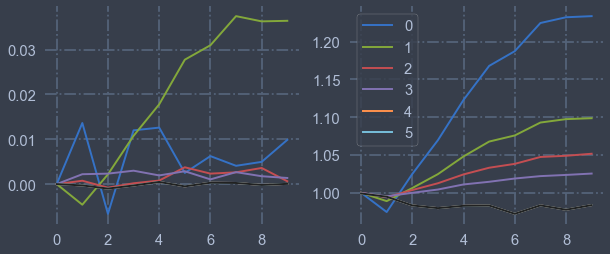

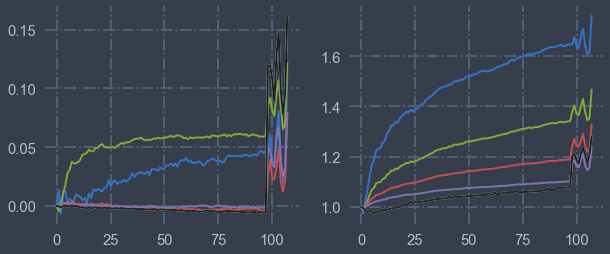

In [16]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [17]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [18]:
%time run.fit(3, learn)

train: [0.27422478515625, tensor(0.9143, device='cuda:0')]
valid: [0.114804638671875, tensor(0.9654, device='cuda:0')]
train: [0.082920771484375, tensor(0.9737, device='cuda:0')]
valid: [0.0948683837890625, tensor(0.9730, device='cuda:0')]
train: [0.06079046875, tensor(0.9810, device='cuda:0')]
valid: [0.080922265625, tensor(0.9767, device='cuda:0')]
Wall time: 18.5 s


In [19]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [21]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [0.21972583984375, tensor(0.9316, device='cuda:0')]
valid: [0.11426494140625, tensor(0.9634, device='cuda:0')]
train: [0.06930994140625, tensor(0.9787, device='cuda:0')]
valid: [0.06501868286132813, tensor(0.9801, device='cuda:0')]
train: [0.0457806787109375, tensor(0.9861, device='cuda:0')]
valid: [0.08164786376953125, tensor(0.9741, device='cuda:0')]
Wall time: 15.7 s


In [27]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.6, 2.), sched_cos(2., 0.1)])

In [28]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [29]:
%time run.fit(8, learn)

train: [0.2598380078125, tensor(0.9228, device='cuda:0')]
valid: [0.1827513427734375, tensor(0.9443, device='cuda:0')]
train: [0.082037119140625, tensor(0.9742, device='cuda:0')]
valid: [0.11366192626953125, tensor(0.9653, device='cuda:0')]
train: [0.054238837890625, tensor(0.9824, device='cuda:0')]
valid: [0.06737581787109374, tensor(0.9800, device='cuda:0')]
train: [0.0315320361328125, tensor(0.9900, device='cuda:0')]
valid: [0.05477529296875, tensor(0.9836, device='cuda:0')]
train: [0.018256295166015624, tensor(0.9942, device='cuda:0')]
valid: [0.04734588317871094, tensor(0.9863, device='cuda:0')]
train: [0.010094517211914062, tensor(0.9970, device='cuda:0')]
valid: [0.0440567626953125, tensor(0.9881, device='cuda:0')]
train: [0.005651048583984375, tensor(0.9991, device='cuda:0')]
valid: [0.0411343994140625, tensor(0.9888, device='cuda:0')]
train: [0.004352924499511719, tensor(0.9994, device='cuda:0')]
valid: [0.04075111389160156, tensor(0.9887, device='cuda:0')]
Wall time: 41.9 s


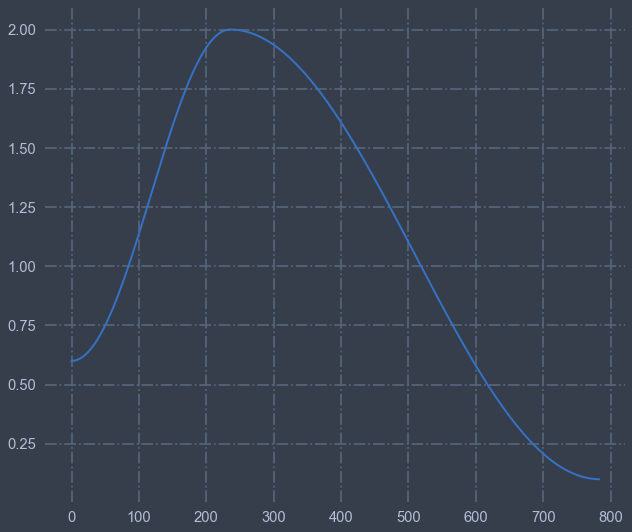

In [30]:
run.recorder.plot_lr()

In [31]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [32]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [33]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [34]:
%time run.fit(1, learn)

train: [0.29571474609375, tensor(0.9137, device='cuda:0')]
valid: [0.09714310913085937, tensor(0.9731, device='cuda:0')]
Wall time: 10.4 s


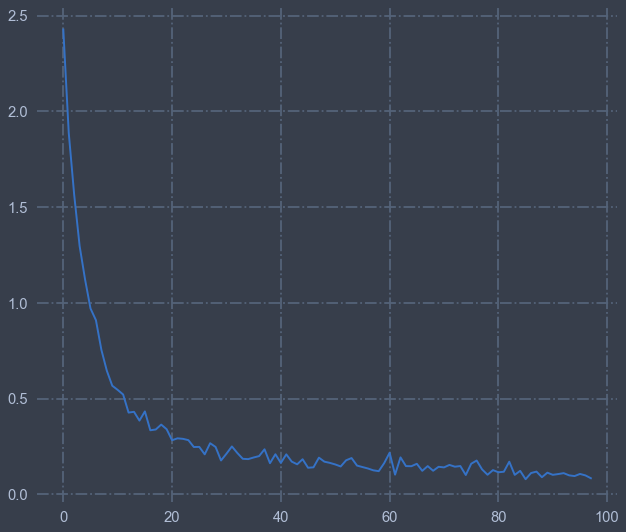

In [36]:
run.recorder.plot_loss()

In [37]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [39]:
learn, run=get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [40]:
run.fit(1, learn)

train: [0.1784775, tensor(0.9461, device='cuda:0')]
valid: [0.07632732543945313, tensor(0.9797, device='cuda:0')]
